# Implementing a Neural Network for CIFAR dataset
In this exercise, you should change H.W_1 to work on the CIFAR dataset.

CIFAR is a dataset that consists of 60,000 32x32 colour images in 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck), with 6000 images per class.

We will have the same components as were in the previous exercise:
- Loading the data and visualize some of the images
- Training the model. Instead of loading a pre-trained model, we will define a new very basic architecture.


## 1) Loading CIFAR dataset

You should load the CIFAR dataset. You can use [the pytorch CIFAR tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). As was done in the previous exercise, you should define a dictionary of ``dataloaders``. For now, no need to define pre-process to the data. 
Please stick to the API of H.W_1, create a dataloaders disctionary ``{'train','val'}``

You can use batch_size = 128

In [1]:
pip install torchvision 

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torchvision
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import os
import time
import copy

In [4]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
### Enter you code here


In [5]:
# Check for the availability of a GPU, and use CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

**If you manage to load the CIFAR data correctly, you should run the next three cells and see some of the images.**

## Visualize some of the training images

In this dataset the size of the images are 32x32. 

It is important to visualize the data in order to see that we load them correctly (maybe we need to divide by 255? should we make channel permutations?) 

The code below was taken from H.W_1

In [7]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[0:16]
classes = classes[0:16]

In [ ]:
inputs , classes

In [9]:
import numpy as np
import matplotlib.pyplot as plt
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5,3), dpi=300)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

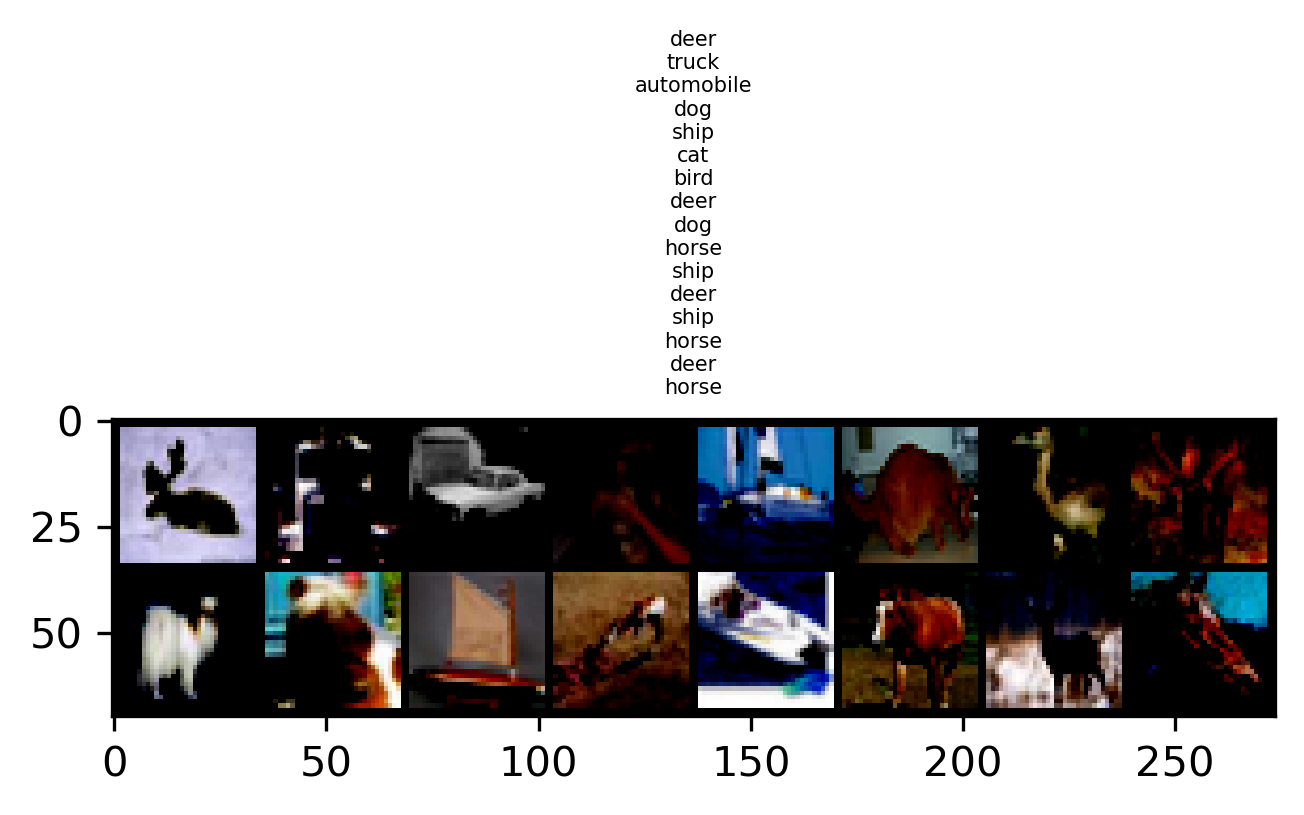

In [10]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)
imshow(out, title='\n'.join([class_names[x] for x in classes]))

## A 2-layer Neural Network

We will define 2-fully-connected-layer network using Sequential module. We have two hidden layers: the first one has 100 neurons and the second one has 20 neurons. The last layer is the output that has 10 elements.

Please pay attention that we take images after flattening (line 17 below).

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [19]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
)


**Pay attention, in case you change something in the parameters, the data, data loaders, image transform, optimizations and more...you should load the model again so it will start from random weights and not from the last training**.

**You should run again the line** ``model = NeuralNetwork().to(device)``


The next two cells (defining the loss and the training loop) were copied from last exercise. 


In [20]:
import torch.optim as optim

# If a GPU is available, make the model use it
model = model.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

In [15]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    acc_val, loss_val, acc_train, loss_train = [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                acc_train.append(epoch_acc.item())
                loss_train.append(epoch_loss)
            else:
                acc_val.append(epoch_acc.item())
                loss_val.append(epoch_loss)           
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    # print(f'acc_val: {acc_val}')
    # print(f'loss_val: {loss_val}')
    # print(f'acc_train: {acc_train}')
    # print(f'loss_train: {loss_train}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_val, loss_val, acc_train, loss_train

In [21]:
%%time
# num_epochs=1
# num_epochs = 10
model, acc_val, loss_val, acc_train, loss_train = train_model(model, 
                                                            dataloaders,
                                                               criterion, 
                                                               optimizer_ft, 
                                                               exp_lr_scheduler,
                                                               num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 2.3057 Acc: 0.1152
val Loss: 2.3009 Acc: 0.1231

Epoch 1/9
----------
train Loss: 2.2963 Acc: 0.1243
val Loss: 2.2905 Acc: 0.1292

Epoch 2/9
----------
train Loss: 2.2862 Acc: 0.1296
val Loss: 2.2793 Acc: 0.1340

Epoch 3/9
----------
train Loss: 2.2753 Acc: 0.1339
val Loss: 2.2672 Acc: 0.1422

Epoch 4/9
----------
train Loss: 2.2636 Acc: 0.1480
val Loss: 2.2543 Acc: 0.1649

Epoch 5/9
----------
train Loss: 2.2509 Acc: 0.1772
val Loss: 2.2404 Acc: 0.1940

Epoch 6/9
----------
train Loss: 2.2370 Acc: 0.2041
val Loss: 2.2252 Acc: 0.2161

Epoch 7/9
----------
train Loss: 2.2288 Acc: 0.2147
val Loss: 2.2236 Acc: 0.2178

Epoch 8/9
----------
train Loss: 2.2273 Acc: 0.2158
val Loss: 2.2220 Acc: 0.2195

Epoch 9/9
----------
train Loss: 2.2257 Acc: 0.2168
val Loss: 2.2203 Acc: 0.2227

Training complete in 1m 47s
Best val Acc: 0.222700
Wall time: 1min 47s


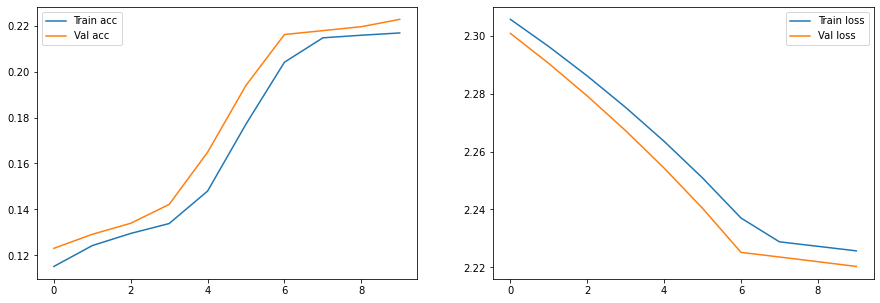

In [22]:
fig, axes =  plt.subplots(1, 2, figsize=(15,5))
axes[0].plot(acc_train, label = 'Train acc')
axes[0].plot(acc_val, label='Val acc')
axes[0].legend()
axes[1].plot(loss_train, label = 'Train loss')
axes[1].plot(loss_val, label='Val loss')
axes[1].legend();

You can continue after you see your model learns something (the training loss is decreasing).

# 2) Losses in Pytorch

Now that you managed to run the training loop, let's understand the loss definition. PyTorch provides losses such as cross-entropy loss (`nn.CrossEntropyLoss`) that has just been used. You'll usually see the loss assigned to `criterion`. For classification problems such as CIFAR, we use the softmax function to predict class probabilities. With a softmax output, we need to use cross-entropy as the loss. To actually calculate the loss, we first define the criterion, then pass in it the output of your network and the correct labels.

*Important note!* Look at [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

It means that we need to pass in `nn.CrossEntropyLoss` the raw output of our network into, not the output of the softmax function. This raw output is usually called the *logits* or *scores*. We use the logits because softmax gives you probabilities, which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually better to avoid doing calculations with probabilities, and generally we use log-probabilities.

**Exercise:** Change the network above to output the log-softmax and calculate the loss using the negative log-likelihood loss. Note that for `nn.LogSoftmax` and `F.log_softmax` you'll need to set the `dim` keyword argument appropriately. `dim=0` calculates softmax across the rows, so each column sums to 1, while `dim=1` calculates across the columns so each row sums to 1. Think about what you want the output to be and choose `dim` appropriately.


In [23]:
class NeuralNetworkLogSoftMax(nn.Module):
    def __init__(self):
        super(NeuralNetworkLogSoftMax, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.LogSoftmax(dim=1)
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [24]:
model_soft = NeuralNetworkLogSoftMax().to(device)
criterion_nll = nn.NLLLoss()
optimizer_ft = optim.SGD(model_soft.parameters(), lr=0.0001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

weight_decay=1e-5

In [25]:
%%time

model_soft, acc_val, loss_val, acc_train, loss_train = train_model(model_soft, 
                                                            dataloaders,
                                                               criterion_nll, 
                                                               optimizer_ft, 
                                                               exp_lr_scheduler,
                                                               num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 2.2912 Acc: 0.1042
val Loss: 2.2745 Acc: 0.1140

Epoch 1/9
----------
train Loss: 2.2564 Acc: 0.1255
val Loss: 2.2386 Acc: 0.1368

Epoch 2/9
----------
train Loss: 2.2210 Acc: 0.1594
val Loss: 2.2035 Acc: 0.1775

Epoch 3/9
----------
train Loss: 2.1870 Acc: 0.1909
val Loss: 2.1704 Acc: 0.2016

Epoch 4/9
----------
train Loss: 2.1554 Acc: 0.2146
val Loss: 2.1396 Acc: 0.2305

Epoch 5/9
----------
train Loss: 2.1263 Acc: 0.2350
val Loss: 2.1113 Acc: 0.2477

Epoch 6/9
----------
train Loss: 2.0997 Acc: 0.2475
val Loss: 2.0852 Acc: 0.2578

Epoch 7/9
----------
train Loss: 2.0857 Acc: 0.2530
val Loss: 2.0828 Acc: 0.2588

Epoch 8/9
----------
train Loss: 2.0833 Acc: 0.2538
val Loss: 2.0803 Acc: 0.2593

Epoch 9/9
----------
train Loss: 2.0809 Acc: 0.2549
val Loss: 2.0778 Acc: 0.2607

Training complete in 1m 45s
Best val Acc: 0.260700
Wall time: 1min 44s


# 3) Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.2 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization. 

**Exersice:** Write this visualization here.
(you can copy your solution from last exercies)


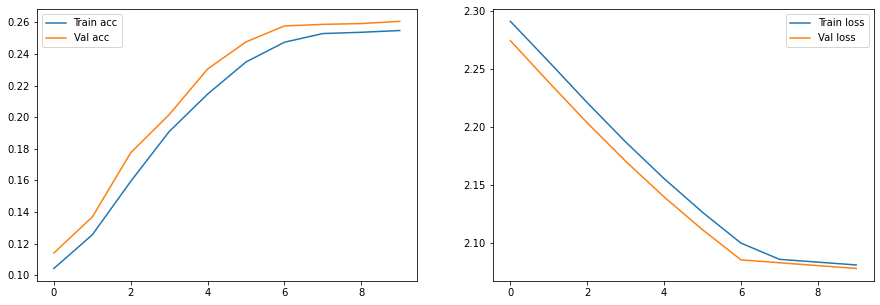

In [26]:
fig, axes =  plt.subplots(1, 2, figsize=(15,5))
axes[0].plot(acc_train, label = 'Train acc')
axes[0].plot(acc_val, label='Val acc')
axes[0].legend()
axes[1].plot(loss_train, label = 'Train loss')
axes[1].plot(loss_val, label='Val loss')
axes[1].legend();

# 4) Tune your hyperparameters

**What's wrong?**. Looking at the loss above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy. 

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including *hidden layer size, learning rate, numer of training epochs, and adding l2 or l1 regularization to the cross entropy loss*. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

**Answer**:  We'll add L2 Regularization by using weight_decay

In [27]:
weight_decay=1e-5
model_tuned = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_tuned = optim.SGD(model_tuned.parameters(), lr=0.0001, momentum=0.9,weight_decay = weight_decay)
exp_lr_scheduler_tuned = lr_scheduler.StepLR(optimizer_tuned, step_size=7, gamma=0.1)

num_epochs = 10

In [28]:
%%time

model_tuned, acc_val, loss_val, acc_train, loss_train = train_model(model_tuned, 
                                                            dataloaders,
                                                               criterion, 
                                                               optimizer_tuned, 
                                                               exp_lr_scheduler_tuned,
                                                               num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 2.3058 Acc: 0.1293
val Loss: 2.2947 Acc: 0.1470

Epoch 1/9
----------
train Loss: 2.2871 Acc: 0.1550
val Loss: 2.2775 Acc: 0.1708

Epoch 2/9
----------
train Loss: 2.2697 Acc: 0.1747
val Loss: 2.2593 Acc: 0.1816

Epoch 3/9
----------
train Loss: 2.2506 Acc: 0.1829
val Loss: 2.2390 Acc: 0.1879

Epoch 4/9
----------
train Loss: 2.2289 Acc: 0.1869
val Loss: 2.2161 Acc: 0.1927

Epoch 5/9
----------
train Loss: 2.2049 Acc: 0.1933
val Loss: 2.1909 Acc: 0.2003

Epoch 6/9
----------
train Loss: 2.1786 Acc: 0.2033
val Loss: 2.1636 Acc: 0.2149

Epoch 7/9
----------
train Loss: 2.1632 Acc: 0.2136
val Loss: 2.1608 Acc: 0.2174

Epoch 8/9
----------
train Loss: 2.1604 Acc: 0.2163
val Loss: 2.1580 Acc: 0.2195

Epoch 9/9
----------
train Loss: 2.1575 Acc: 0.2183
val Loss: 2.1551 Acc: 0.2212

Training complete in 1m 47s
Best val Acc: 0.221200
Wall time: 1min 47s


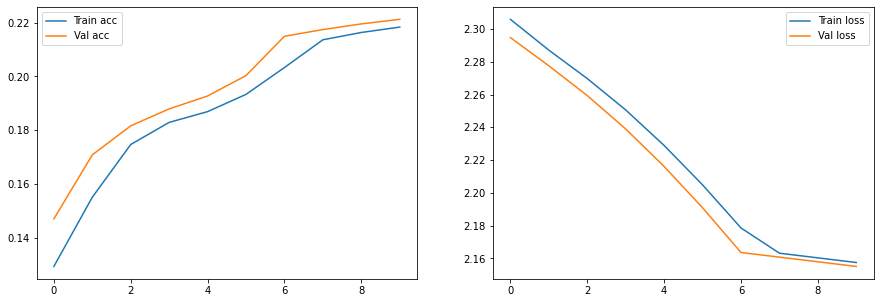

In [29]:
fig, axes =  plt.subplots(1, 2, figsize=(15,5))
axes[0].plot(acc_train, label = 'Train acc')
axes[0].plot(acc_val, label='Val acc')
axes[0].legend()
axes[1].plot(loss_train, label = 'Train loss')
axes[1].plot(loss_val, label='Val loss')
axes[1].legend();

**Answer:** Adding reguralization didn't improve the accuracy as we can from the plot above.   
We change the batch size now to 4 in order to try to improve the accuracy

In [31]:
batch_size_tuned = 4

dataloaders_tuned = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size_tuned,
                                          shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size_tuned,
                                         shuffle=False, num_workers=2)
  }

model_tuned = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_tuned = optim.SGD(model_tuned.parameters(), lr=0.0001, momentum=0.9)
exp_lr_scheduler_tuned = lr_scheduler.StepLR(optimizer_tuned, step_size=7, gamma=0.1)

num_epochs = 10

In [32]:
%%time

model_tuned, acc_val, loss_val, acc_train, loss_train = train_model(model_tuned, 
                                                            dataloaders_tuned,
                                                               criterion, 
                                                               optimizer_tuned, 
                                                               exp_lr_scheduler_tuned,
                                                               num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 2.0007 Acc: 0.2848
val Loss: 1.7892 Acc: 0.3686

Epoch 1/9
----------
train Loss: 1.7018 Acc: 0.3991
val Loss: 1.6257 Acc: 0.4302

Epoch 2/9
----------
train Loss: 1.5895 Acc: 0.4398
val Loss: 1.5524 Acc: 0.4494

Epoch 3/9
----------
train Loss: 1.5162 Acc: 0.4654
val Loss: 1.4983 Acc: 0.4693

Epoch 4/9
----------
train Loss: 1.4577 Acc: 0.4863
val Loss: 1.4630 Acc: 0.4819

Epoch 5/9
----------
train Loss: 1.4083 Acc: 0.5035
val Loss: 1.4346 Acc: 0.4957

Epoch 6/9
----------
train Loss: 1.3662 Acc: 0.5205
val Loss: 1.4123 Acc: 0.5018

Epoch 7/9
----------
train Loss: 1.3009 Acc: 0.5452
val Loss: 1.3873 Acc: 0.5125

Epoch 8/9
----------
train Loss: 1.2906 Acc: 0.5505
val Loss: 1.3838 Acc: 0.5143

Epoch 9/9
----------
train Loss: 1.2844 Acc: 0.5529
val Loss: 1.3813 Acc: 0.5163

Training complete in 4m 14s
Best val Acc: 0.516300
Wall time: 4min 14s


**Answer:** As we can see from the results above, changing the batch size to 4 improved the accuracy so we can get the required level of 52%

# Interview Question

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.
1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

**answer**:
Train on a larger dataset.

**explanation:**
Presence of more data results in better and accurate models.
